# Mackenzie Box time series

In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

## import required packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob
import pathlib as Path
import os
import re
import cmocean
import matplotlib.cm as cm

## Loading SIA gifs

In [2]:
from datetime import timedelta, datetime

def date_to_iter_number(date,seconds_per_iter = 3600):
    total_seconds = (date-datetime(1992,1,1)).total_seconds()
    iter_number = total_seconds/seconds_per_iter
    return(iter_number)

def iter_number_to_date(iter_number,seconds_per_iter=3600):
    total_seconds = iter_number*seconds_per_iter
    date = datetime(1992,1,1) + timedelta(seconds=total_seconds)
    return(date)

In [96]:
# ---------------------------------------------------------------
# Check november dates -- can change to your year as required
# ---------------------------------------------------------------
from datetime import timedelta, datetime

oct_2014_start = date_to_iter_number(datetime(2016,10,1))
dec_2014_end = date_to_iter_number(datetime(2016,12,31))

In [97]:
# --------------------------------------------
# Load in three months of data -- November 2014
# --------------------------------------------

geom = xr.open_dataset('/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc')

# input_dir = '/efs_ecco/mzahn/r5/WORKINGDIR/ECCOV4/release5/run/diags/SIarea_daily_mean'
input_dir = '/efs_ecco/cwilliam/r5/WORKINGDIR/ECCOV4/release5/run/diags/SIarea_daily_mean'
pattern = os.path.join(input_dir, 'SIarea_daily_mean.*.data')
file_list = sorted(glob.glob(pattern))

# Define your range
start_num = oct_2014_start
end_num = dec_2014_end

siarea_DA_list = []

for filepath in file_list:
    filename = os.path.basename(filepath);
    
    # Extract last 6 digits using regex
    match = re.search(r'(\d{6})\.data$', filename)
    if match:
        number = int(match.group(1))
        if start_num <= number <= end_num:
            siarea_test = ecco.read_llc_to_tiles(input_dir, filename, llc=90, skip=0, nk=1, less_output=True);
            siarea_test = np.where(geom.hFacC.isel(k=0) == 1, siarea_test, np.nan);

            tile = range(1, 14)
            i = range(90)
            j = range(90)
            time = iter_number_to_date(number)

            siarea_DA = xr.DataArray(
                siarea_test.reshape(1, 13, 90, 90),
                coords={'time': time, 'tile': tile, 'j': j, 'i': i},
                dims=['k', 'tile', 'j', 'i']
            );

            siarea_DA_list.append(siarea_DA);

# Concatenate all valid files
siarea_OND2014 = xr.concat(siarea_DA_list, dim='time');

In [98]:
# --------------------------------------------
# Load in three months of data -- November 2014
# --------------------------------------------

geom = xr.open_dataset('/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc')

input_dir = '/efs_ecco/obousque/r5/WORKINGDIR/ECCOV4/release5/run/diags/SIarea_daily_mean'
pattern = os.path.join(input_dir, 'SIarea_daily_mean.*.data')
file_list = sorted(glob.glob(pattern))

# Define your range
start_num = oct_2014_start
end_num = dec_2014_end

siarea_DA_list = []

for filepath in file_list:
    filename = os.path.basename(filepath);
    
    # Extract last 6 digits using regex
    match = re.search(r'(\d{6})\.data$', filename)
    if match:
        number = int(match.group(1))
        if start_num <= number <= end_num:
            siarea_test = ecco.read_llc_to_tiles(input_dir, filename, llc=90, skip=0, nk=1, less_output=True);
            siarea_test = np.where(geom.hFacC.isel(k=0) == 1, siarea_test, np.nan);

            tile = range(1, 14)
            i = range(90)
            j = range(90)
            time = iter_number_to_date(number)

            siarea_DA = xr.DataArray(
                siarea_test.reshape(1, 13, 90, 90),
                coords={'time': time, 'tile': tile, 'j': j, 'i': i},
                dims=['k', 'tile', 'j', 'i']
            );

            siarea_DA_list.append(siarea_DA);

# Concatenate all valid files
siarea_control_OND2014 = xr.concat(siarea_DA_list, dim='time');

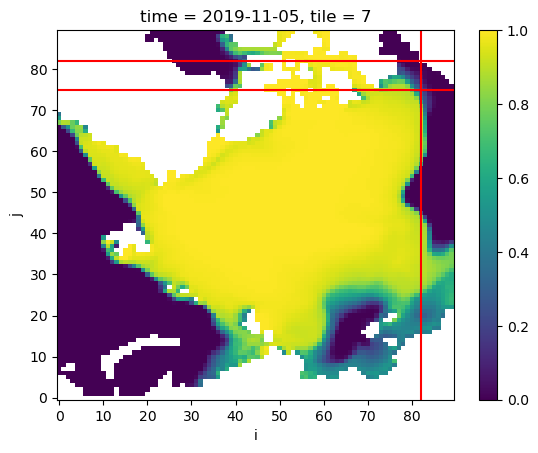

In [6]:
siarea_control_OND2014.isel(tile=6,time=35).plot();
# plt.axvline(x=85,c='r')
# plt.axvline(x=90,c='r')
# plt.axhline(y=71,c='r')
# plt.axhline(y=79,c='r');

plt.axvline(x=82,c='r')
plt.axvline(x=90,c='r')
plt.axhline(y=75,c='r')
plt.axhline(y=82,c='r');

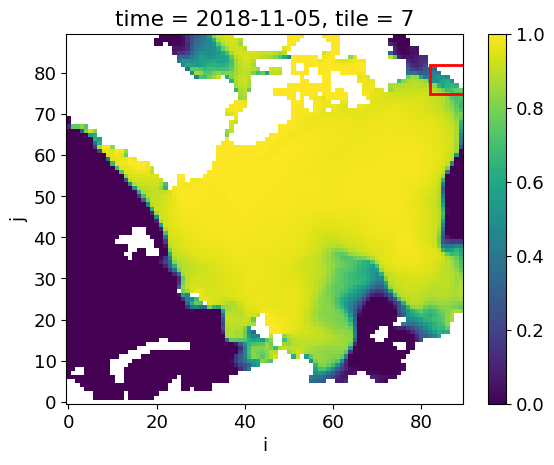

In [21]:
# Plot the data
siarea_control_OND2014.isel(tile=6, time=35).plot()

# Define box parameters
x_start, x_end = 82, 90
y_start, y_end = 75, 82
width = x_end - x_start
height = y_end - y_start

# Add a red rectangle
rect = plt.Rectangle((x_start, y_start), width, height,
                     linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect);

In [99]:
sic_mean_vary = siarea_OND2014.isel(k=0,tile=6,i=slice(82,90),j=slice(75,82)).mean(dim=['i','j']) * 100
sic_mean_cont = siarea_control_OND2014.isel(k=0,tile=6,i=slice(82,90),j=slice(75,82)).mean(dim=['i','j']) * 100

In [100]:
# Mask values that are below or equal to 15%
sic_date_vary = sic_mean_vary.sel(time=sic_mean_vary>=15).time.values[0]
sic_date_cont = sic_mean_cont.sel(time=sic_mean_cont>=15).time.values[0]

Text(0.5, 1.0, 'Sea ice concentration for Mackenzie River Box - 2019')

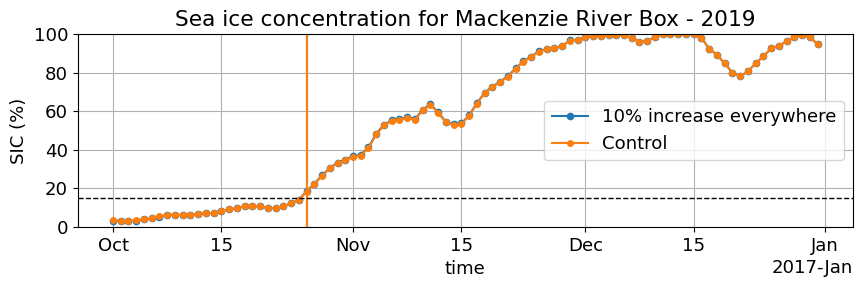

In [102]:
plt.rcParams['font.size'] = 13

# sic_mean_vary.plot(label='Time-varying',figsize=[10,2.5],color='tab:blue',marker='o',markersize=4.5);
sic_mean_vary.plot(label='10% increase everywhere',figsize=[10,2.5],color='tab:blue',marker='o',markersize=4.5);
sic_mean_cont.plot(label='Control',color='tab:orange',marker='o',markersize=4);

plt.axvline(x=sic_date_vary,color='tab:blue')
plt.axvline(x=sic_date_cont,color='tab:orange')

plt.axhline(y=15,color='k',linewidth=1,linestyle='dashed')
plt.grid()
plt.legend()
plt.ylim([0,100])
plt.ylabel('SIC (%)')
plt.title('Sea ice concentration for Mackenzie River Box - 2019')

# plt.xlim([np.datetime64('2017-11-01'),np.datetime64('2017-11-13')]);